In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models

In [3]:
import imageio
import time
import random
import copy
import sys
import json
from PIL import Image

### define data paths

In [4]:
data_dir = './flower_data/'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')

### preprocess data

In [5]:
data_transforms = {
    'train': 
    transforms.Compose([
        # Resize images to same pixels
        transforms.Resize((96, 96)),
        # Data augmentation
        transforms.RandomRotation(45), # rotate the image randomly within 45 degrees
        transforms.CenterCrop(64),     # crop the center 64x64 pixels
        transforms.RandomHorizontalFlip(p=0.5),  # randomly flip the image horizontally
        transforms.RandomVerticalFlip(p=0.5),    # randomly flip the image vertically
        #transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1), # randomly change brightness, contrast, saturation and hue
        transforms.RandomGrayscale(p=0.025), # randomly convert image to grayscale
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # RGB mean and std for normalization
    ]),
    'valid': 
    transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ]),
}



In [6]:
batch_size = 128

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
datasets_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [7]:
class_names

['1',
 '10',
 '100',
 '101',
 '102',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '8',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '9',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99']

In [8]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 6552
     Root location: ./flower_data/train
     StandardTransform
 Transform: Compose(
                Resize(size=(96, 96), interpolation=bilinear, max_size=None, antialias=True)
                RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                CenterCrop(size=(64, 64))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                RandomGrayscale(p=0.025)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 818
     Root location: ./flower_data/valid
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [9]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [10]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

### Load backbone model

In [11]:
model_name = 'resnet50'

feature_extract = True

In [12]:
available = torch.cuda.is_available()

if available:
    print("CUDA is available. Training on GPU.")
else:
    print("CUDA is not available. Training on CPU.")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is available. Training on GPU.


In [13]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [14]:
model_ft = models.resnet50()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
model_ft = models.resnet50(pretrained=True)

# Freeze all layers except the final fully connected layer
set_parameter_requires_grad(model_ft, feature_extract)

# Modify the final layer to match the number of classes in the flower dataset
num_in = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_in, 102)  # 102 flower classes



/home/campus.ncl.ac.uk/c0045893/devtools/anaconda3/envs/gans-research/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/campus.ncl.ac.uk/c0045893/devtools/anaconda3/envs/gans-research/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
model_ft = model_ft.to(device)

filename='best.pth'

if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
else:
    params_to_update = model_ft.parameters()

print("Params to learn:")
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [18]:
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [19]:
since = time.time()

best_acc = 0.0

val_acc_history = []
train_acc_history = []
train_losses = []
valid_losses = []

LRs= [optimizer_ft.param_groups[0]['lr']]

best_model_wts = copy.deepcopy(model_ft.state_dict())

for epoch in range(20):
    print('Epoch {}/{}'.format(epoch+1, 20))
    print('-' * 10)

    for phase in ['train', 'valid']:
        if phase == 'train':
            model_ft.train()
        else:
            model_ft.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer_ft.zero_grad()
            outputs = model_ft(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            if phase == 'train':
                loss.backward()
                optimizer_ft.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

        time_elapsed = time.time() - since
        print('{} Loss: {:.4f} Acc: {:.4f} Time: {:.0f}m {:.0f}s'.format(
            phase, epoch_loss, epoch_acc, time_elapsed // 60, time_elapsed % 60))
        
        if phase == 'valid' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model_ft.state_dict())
            state = {
                'state_dict': model_ft.state_dict(),
                'optimizer': optimizer_ft.state_dict(),
                'best_acc': best_acc,
            }
            torch.save(state, filename)
            print("Model saved to %s" % filename)

        if phase == 'valid':
            val_acc_history.append(epoch_acc)
            valid_losses.append(epoch_loss)
        if phase == 'train':
            train_acc_history.append(epoch_acc)
            train_losses.append(epoch_loss)

    print('Optimizer learning rate: {:.7f}'.format(optimizer_ft.param_groups[0]['lr']))
    LRs.append(optimizer_ft.param_groups[0]['lr'])
    print()
    scheduler.step()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

Epoch 1/20
----------
train Loss: 6.0972 Acc: 0.2721 Time: 0m 5s
valid Loss: 4.6334 Acc: 0.2800 Time: 0m 6s
Model saved to best.pth
Optimizer learning rate: 0.0100000

Epoch 2/20
----------
train Loss: 3.1950 Acc: 0.4557 Time: 0m 11s
valid Loss: 4.9333 Acc: 0.3484 Time: 0m 12s
Model saved to best.pth
Optimizer learning rate: 0.0100000

Epoch 3/20
----------
train Loss: 3.1008 Acc: 0.4915 Time: 0m 17s
valid Loss: 5.1883 Acc: 0.2958 Time: 0m 18s
Optimizer learning rate: 0.0100000

Epoch 4/20
----------
train Loss: 3.0330 Acc: 0.5208 Time: 0m 23s
valid Loss: 5.0471 Acc: 0.3496 Time: 0m 24s
Model saved to best.pth
Optimizer learning rate: 0.0100000

Epoch 5/20
----------
train Loss: 2.9898 Acc: 0.5420 Time: 0m 29s
valid Loss: 5.6791 Acc: 0.3411 Time: 0m 30s
Optimizer learning rate: 0.0100000

Epoch 6/20
----------
train Loss: 2.9916 Acc: 0.5487 Time: 0m 35s
valid Loss: 5.5149 Acc: 0.3582 Time: 0m 36s
Model saved to best.pth
Optimizer learning rate: 0.0100000

Epoch 7/20
----------
train Lo

In [20]:
model_ft.load_state_dict(best_model_wts)

<All keys matched successfully>

### unfreeze the entire model for fine-tuning

In [21]:
for param in model_ft.parameters():
    param.requires_grad = True

optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

criterion = nn.CrossEntropyLoss()

In [22]:
checkpoint = torch.load('best.pth')
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [23]:
since = time.time()

best_acc = 0.0

val_acc_history = []
train_acc_history = []
train_losses = []
valid_losses = []

LRs= [optimizer_ft.param_groups[0]['lr']]

best_model_wts = copy.deepcopy(model_ft.state_dict())

for epoch in range(10):
    print('Epoch {}/{}'.format(epoch+1, 10))
    print('-' * 10)

    for phase in ['train', 'valid']:
        if phase == 'train':
            model_ft.train()
        else:
            model_ft.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer_ft.zero_grad()
            outputs = model_ft(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            if phase == 'train':
                loss.backward()
                optimizer_ft.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

        time_elapsed = time.time() - since
        print('{} Loss: {:.4f} Acc: {:.4f} Time: {:.0f}m {:.0f}s'.format(
            phase, epoch_loss, epoch_acc, time_elapsed // 60, time_elapsed % 60))
        
        if phase == 'valid' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model_ft.state_dict())
            state = {
                'state_dict': model_ft.state_dict(),
                'optimizer': optimizer_ft.state_dict(),
                'best_acc': best_acc,
            }
            torch.save(state, filename)
            print("Model saved to %s" % filename)

        if phase == 'valid':
            val_acc_history.append(epoch_acc)
            valid_losses.append(epoch_loss)
        if phase == 'train':
            train_acc_history.append(epoch_acc)
            train_losses.append(epoch_loss)

    print('Optimizer learning rate: {:.7f}'.format(optimizer_ft.param_groups[0]['lr']))
    LRs.append(optimizer_ft.param_groups[0]['lr'])
    print()
    scheduler.step()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

Epoch 1/10
----------
train Loss: 1.2161 Acc: 0.7433 Time: 0m 5s
valid Loss: 4.1320 Acc: 0.5098 Time: 0m 6s
Model saved to best.pth
Optimizer learning rate: 0.0001000

Epoch 2/10
----------
train Loss: 0.8018 Acc: 0.8120 Time: 0m 12s
valid Loss: 2.9580 Acc: 0.5685 Time: 0m 12s
Model saved to best.pth
Optimizer learning rate: 0.0001000

Epoch 3/10
----------
train Loss: 0.6477 Acc: 0.8405 Time: 0m 18s
valid Loss: 2.3301 Acc: 0.5856 Time: 0m 19s
Model saved to best.pth
Optimizer learning rate: 0.0001000

Epoch 4/10
----------
train Loss: 0.4877 Acc: 0.8706 Time: 0m 24s
valid Loss: 2.0992 Acc: 0.6002 Time: 0m 25s
Model saved to best.pth
Optimizer learning rate: 0.0001000

Epoch 5/10
----------
train Loss: 0.3647 Acc: 0.8962 Time: 0m 31s
valid Loss: 2.0601 Acc: 0.6345 Time: 0m 32s
Model saved to best.pth
Optimizer learning rate: 0.0001000

Epoch 6/10
----------
train Loss: 0.3153 Acc: 0.9095 Time: 0m 37s
valid Loss: 1.9871 Acc: 0.6455 Time: 0m 38s
Model saved to best.pth
Optimizer learning

### load the best model weights

In [24]:
checkpoint = torch.load('best.pth')
best_acc = checkpoint['best_acc']

model_ft.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

In [30]:
best_acc

tensor(0.6748, device='cuda:0', dtype=torch.float64)

In [25]:
# get a batch of validation data
dataiter = iter(dataloaders['valid'])
images, labels = next(dataiter)

model_ft.eval()

if available:
    images = images.cuda()
    labels = labels.cuda()

outputs = model_ft(images)



In [26]:
outputs.shape

torch.Size([128, 102])

In [27]:
_, preds = torch.max(outputs, 1)

preds = np.squeeze(preds.cpu().numpy() if not available else np.squeeze(preds.cpu().numpy()))
preds

array([ 46,  84,  67,  22,  38,  84,  89,  73,  85,   5,  89,  73,  79,
        18,  77,  80,  96,  74,   2,  62,  84, 100,  85,  43,   0,  19,
         4,  97,  75,  66,  89,  77,  57,  41,  38,  59, 100,  82,  29,
        76,  24,  99,   1,  38,  54,  78,  61,  96,  11,  11,  60,  61,
        26,  84,  53,  45,  49,  14,  16,  94,  98,  47,  50,  38,  62,
         5,  96,  75,  50,  53,  32,  77,  99,  77,  78,  82,  15,  79,
        11,   5,  89, 100,  46,  42,  78,  81,   2,  35,  82,  77,  84,
        17,  81,  57,  85,  77,   1,  43,  16,  65,  38,  33,  65,  87,
        81,  85,   3,  50,  81,  56,  93,  36,  36,  53,  43,  68,  43,
        90,  49,   4,  48,  35,  89,  53,   9,  85,  49,  39])

In [28]:
def im_convert(tensor):
    """ 展示数据"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

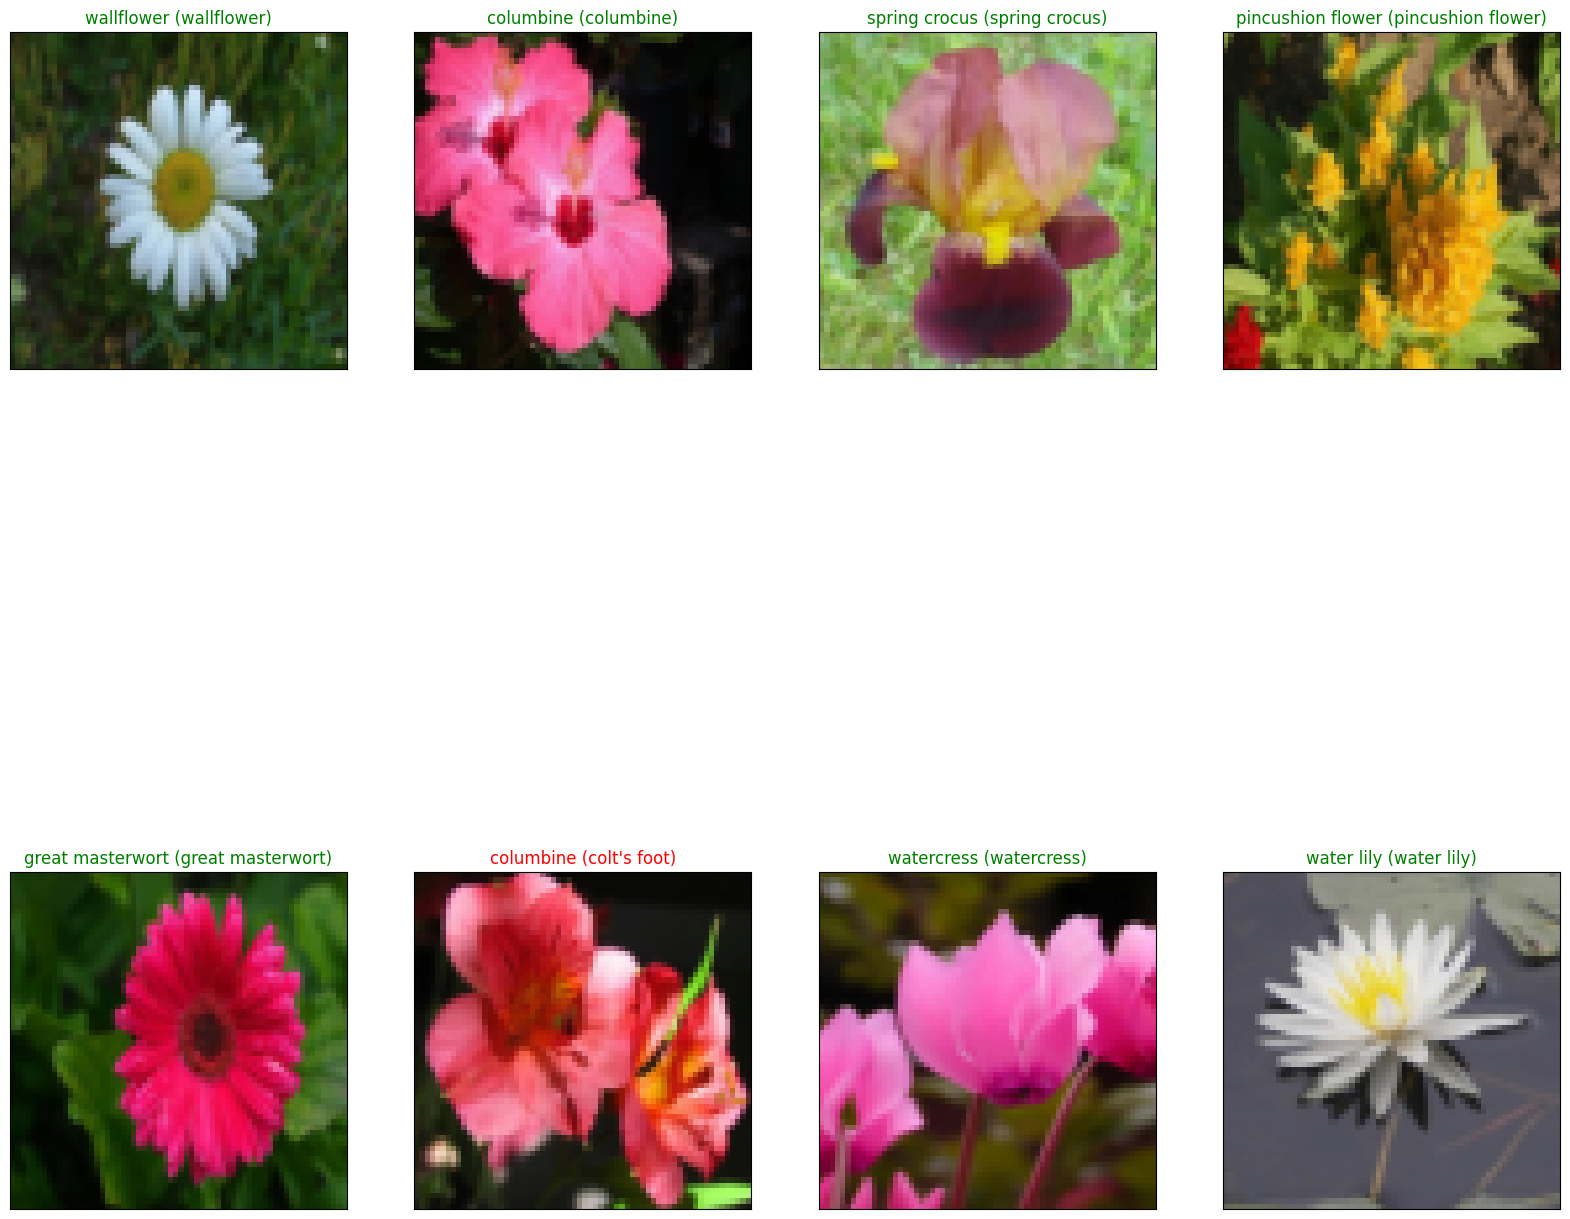

In [29]:
fig=plt.figure(figsize=(20, 20))
columns =4
rows = 2

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(cat_to_name[str(preds[idx])], cat_to_name[str(labels[idx].item())]),
                 color=("green" if cat_to_name[str(preds[idx])]==cat_to_name[str(labels[idx].item())] else "red"))
plt.show()